## DenseNet201

In [1]:
# installs
!pip install monai # model
!pip install medmnist # data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=84b7b7f3f0e86d2c9231919d0646d821948b58fb298c2d60276a7e823e898a50
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from medmnist import RetinaMNIST
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize
from monai.networks.blocks import MLPBlock
from torchvision import models, transforms

import monai
from monai.apps import download_and_extract
from monai.data import CacheDataset, DataLoader, pad_list_data_collate, partition_dataset
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism

from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load Data Set

In [3]:
# load RetinaMNIST dataset
def get_retina_mnist_data(split, transform=None):
    return RetinaMNIST(split=split, transform=transform, download=True, as_rgb=True)

# preprocessing transformation for the RetinaMNIST images
transform = transforms.Compose([
    transforms.Resize(256),  # resize the image to at least 256 pixels in the smaller dimension
    transforms.CenterCrop(224),  # crop the center of the image to 224x224 pixels (required by ResNet)
    transforms.ToTensor(),  # convert the image to a PyTorch tensor (values scaled to [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize using ImageNet stats
])

# load train and validation splits
train_dataset = get_retina_mnist_data("train", transform)
val_dataset = get_retina_mnist_data("val", transform)

100%|██████████| 3.29M/3.29M [00:03<00:00, 896kB/s] 

Using downloaded and verified file: /root/.medmnist/retinamnist.npz


## Dataloaders

In [4]:
# define batch size
batch_size = 32
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Define Model

In [5]:
# load pretrained DenseNet201 model from MONAI
model = monai.networks.nets.DenseNet201(
    spatial_dims=2,          # 2D input images
    in_channels=3,           # 3 input channels for RetinaMNIST (RGB)
    out_channels=5           # 5 output classes for classification
)

In [6]:
# move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet201(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

In [7]:
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # adam optimizer

## Train

In [8]:
# training loop
num_epochs = 200
train_acc = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:  # assume train_loader is defined
        inputs, labels = inputs.to(device), labels.squeeze().to(device)

        optimizer.zero_grad()  # Zero the gradients before each backward pass
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total  # Calculate accuracy
    train_acc.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/200, Loss: 1.3258, Accuracy: 46.57%
Epoch 2/200, Loss: 1.2502, Accuracy: 49.35%
Epoch 3/200, Loss: 1.2191, Accuracy: 48.24%
Epoch 4/200, Loss: 1.2308, Accuracy: 50.65%
Epoch 5/200, Loss: 1.2049, Accuracy: 51.20%
Epoch 6/200, Loss: 1.1781, Accuracy: 51.94%
Epoch 7/200, Loss: 1.1724, Accuracy: 50.28%
Epoch 8/200, Loss: 1.1767, Accuracy: 52.59%
Epoch 9/200, Loss: 1.1851, Accuracy: 50.37%
Epoch 10/200, Loss: 1.1703, Accuracy: 51.76%
Epoch 11/200, Loss: 1.1692, Accuracy: 51.30%
Epoch 12/200, Loss: 1.1899, Accuracy: 52.41%
Epoch 13/200, Loss: 1.1697, Accuracy: 50.19%
Epoch 14/200, Loss: 1.1933, Accuracy: 52.59%
Epoch 15/200, Loss: 1.1509, Accuracy: 52.87%
Epoch 16/200, Loss: 1.1505, Accuracy: 53.43%
Epoch 17/200, Loss: 1.1332, Accuracy: 52.41%
Epoch 18/200, Loss: 1.1363, Accuracy: 53.06%
Epoch 19/200, Loss: 1.1332, Accuracy: 52.31%
Epoch 20/200, Loss: 1.1277, Accuracy: 53.61%
Epoch 21/200, Loss: 1.2569, Accuracy: 51.39%
Epoch 22/200, Loss: 1.2613, Accuracy: 50.28%
Epoch 23/200, Loss:

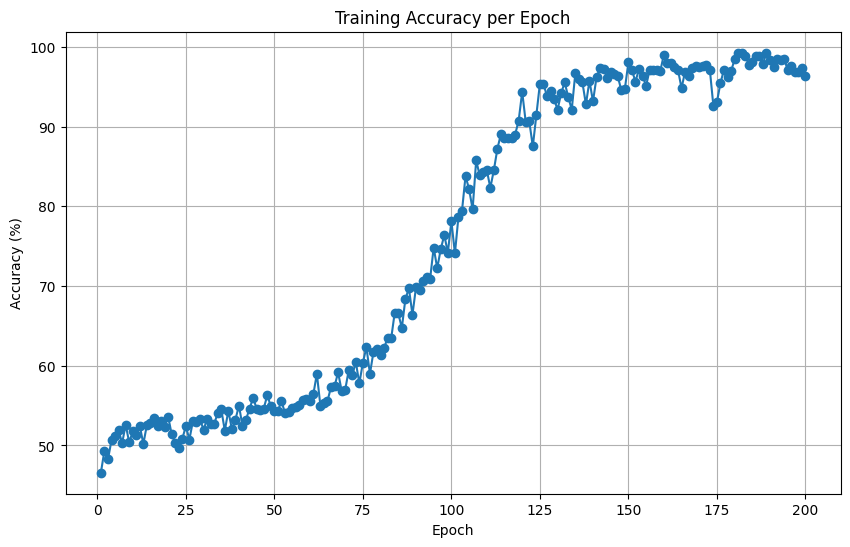

In [9]:
# Plot Training Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_acc, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy per Epoch")
plt.grid()
plt.show()

## Display Example Predictions

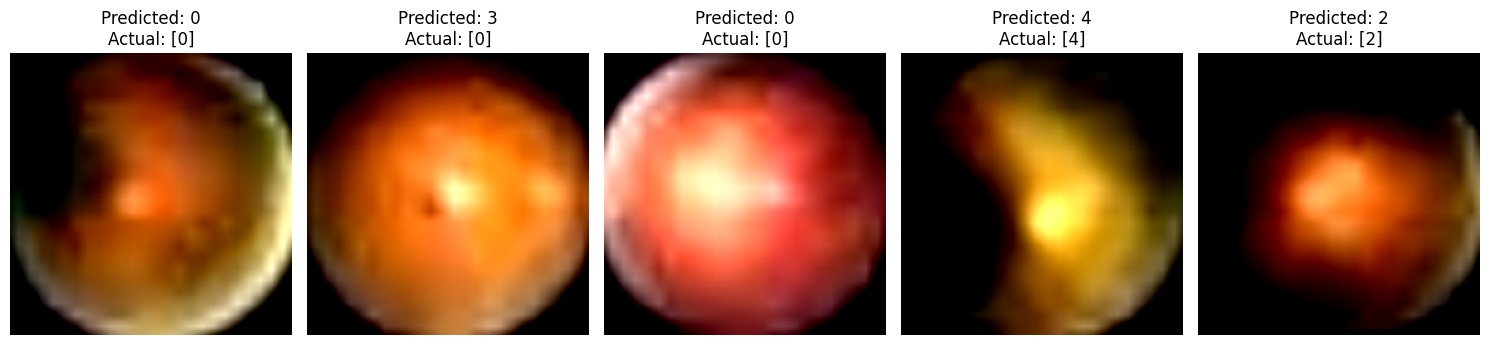

In [10]:
import random
import matplotlib.pyplot as plt

# Function to display random samples with predictions and actual labels
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    # loop over each randomly selected sample index
    for i, idx in enumerate(samples):
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        with torch.no_grad():
            output = model(image_tensor)
            predicted_label = torch.argmax(output, 1).item()

        # move the image back to CPU for visualization
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * 0.5) + 0.5  # undo normalization for visualization
        # plot the image on the corresponding axis
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Predicted: {predicted_label}\nActual: {label}")

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, val_dataset, num_samples=5)

## Confusion Matrix

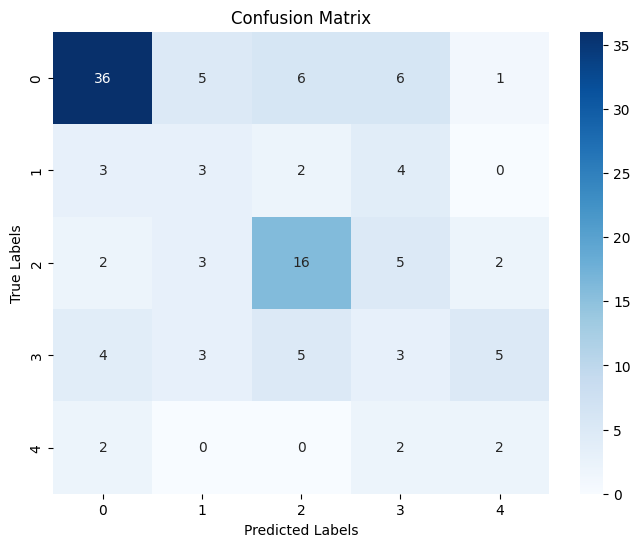

In [11]:
# plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# generate confusion matrix
def generate_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No need to track gradients during inference
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_preds.extend(predicted.cpu().numpy())  # Store predicted labels

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Define the class names (adjust if necessary based on your dataset)
    class_names = [str(i) for i in range(5)]  # Assuming 5 classes (0 to 4)

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names)

generate_confusion_matrix(model, val_loader)

## Saliency

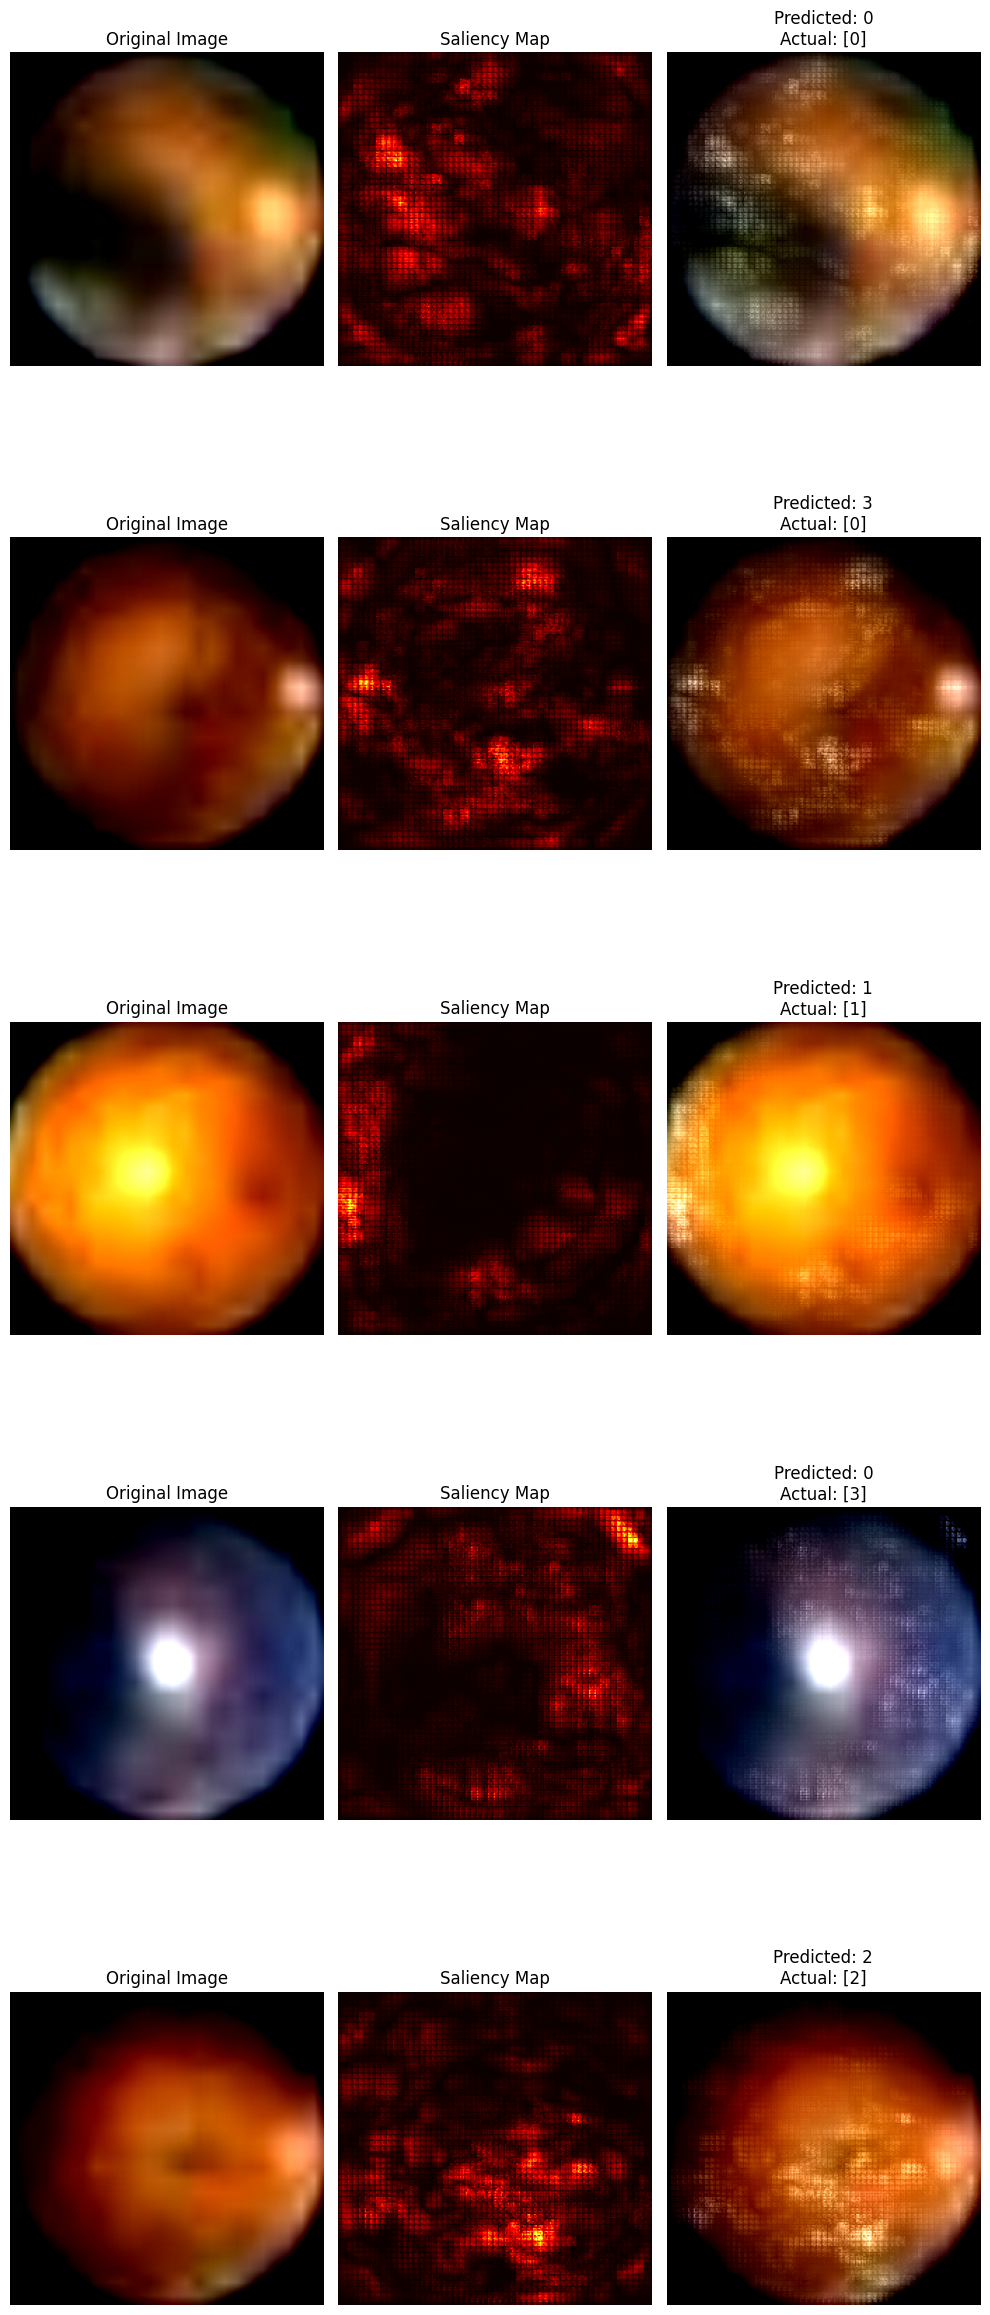

In [12]:
def visualize_saliency(model, dataset, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(dataset)), num_samples)  # Randomly sample from the dataset

    # Create a subplot grid (num_samples rows, 3 columns for original, saliency map, and overlay)
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(samples):
        image, label = dataset[idx]  # Get the image and its label from the dataset
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to the device (GPU/CPU)

        image_tensor.requires_grad_()  # Enable gradient tracking for the image tensor

        # Forward pass to get model predictions
        output = model(image_tensor)  # Forward pass through the model
        predicted_label = torch.argmax(output, 1).item()  # Get the predicted class

        # Compute gradients of the output w.r.t the input image
        model.zero_grad()  # Reset gradients from the previous backward pass
        output[0, predicted_label].backward()  # Backpropagate to get the gradient for the predicted class
        saliency = image_tensor.grad.abs().squeeze().cpu().numpy()  # Get the saliency map (absolute gradient)

        # Normalize the saliency map (optional but useful for visualization)
        saliency = saliency.max(axis=0)  # Take the maximum saliency value across channels (for RGB)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize to [0, 1]

        # Undo normalization for the original image (to bring it back to [0, 1] for display)
        image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert the image to numpy (H, W, C)
        image_np = (image_np * 0.5) + 0.5  # Undo the normalization (from [-1, 1] back to [0, 1])

        # Overlay saliency map on top of the original image
        overlay = np.clip(image_np + np.expand_dims(saliency, axis=-1), 0, 1)  # Combine saliency with the image

        # Plot the original image, the saliency map, and the overlay
        axes[i, 0].imshow(image_np)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original Image")

        axes[i, 1].imshow(saliency, cmap="hot")  # Display the saliency map with a 'hot' colormap
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Saliency Map")

        axes[i, 2].imshow(overlay)  # Display the image with the saliency map overlaid
        axes[i, 2].axis("off")
        axes[i, 2].set_title(f"Predicted: {predicted_label}\nActual: {label}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Call the function to visualize saliency maps on the validation dataset
visualize_saliency(model, val_dataset, num_samples=5)